In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors
import seaborn as sns

import scipy.stats

In [2]:
CAREER_LENGTH = 5

EARLY_CAREER_LEN = 3
QUALITY_CUT_OFF = 5

## Load data

In [29]:
credible_authors = pd.read_csv('derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')

In [6]:
credible_authors.head()

,author,start_year,end_year,num_pub,career_length,early_career_qual,early_career_prod,early_career_pubs,early_career_rec,gender
0,'maseka lesaoana,2001,2015,2,15,5.0,1,['4ff8ca7b-16b7-4bc8-b235-1eeac9b2aefa'],0,none
1,a aart blokhuis,1992,2005,2,14,0.0,1,['f80ada7b-a8ef-43b0-b1c7-5c35f8cd0ea8'],0,none
2,a min tjoa,1979,2017,191,39,0.0,1,['608eb4db-5623-4467-aba6-b7762abefe20'],0,none
3,a-imam al-sammak,1992,2006,3,15,0.0,1,['14528920-bfbd-457c-ace2-b4422ea6aafd'],0,m
4,a-long jin,2011,2016,9,6,0.0,1,['86a055b7-36a9-4b03-b9d4-71725e5d5b0d'],0,none


In [42]:
authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-5-year.csv')
authorPublicationData.head()

,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,dae-seok rho,2011,00338203-9eb3-40c5-9f31-cbac73a519ec


## Test for errors in files

### Test if final citation count is working correctly

In [30]:
final_less_than_early = credible_authors[credible_authors.final_citation_count < credible_authors.early_career_qual].shape
assert final_less_than_early[0] == 0, "Final citation count is smaller than early in {} cases.".format(final_less_than_early[0])

In [31]:
credible_authors[credible_authors.final_citation_count < credible_authors.early_career_qual].head()

,author,start_year,end_year,num_pub,career_length,early_career_qual,early_career_prod,early_career_pubs,early_career_rec,gender,final_citation_count


In [32]:
# Look for authors with more than 20K citations. Are they famous?
authors_5k = credible_authors[credible_authors['final_citation_count'] > 5000]

In [33]:
authors_5k.index

Int64Index([   894,   1329,   1762,   1858,   1883,   4940,   5620,   6267,
              8196,   9689,
            ...
            498179, 498672, 499305, 499369, 501412, 501467, 501650, 501852,
            502744, 503600],
           dtype='int64', length=915)

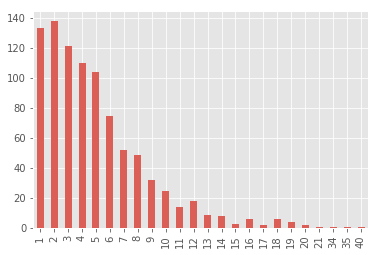

In [34]:
authors_5k.early_career_prod.value_counts().sort_index().plot(kind='bar')

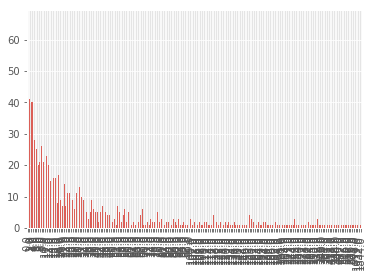

In [35]:
authors_5k.early_career_qual.value_counts().sort_index().plot(kind='bar')

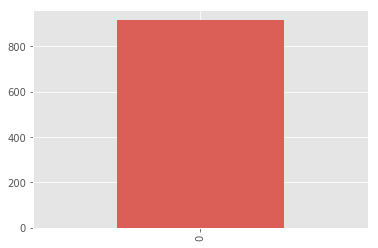

In [36]:
authors_5k.early_career_rec.value_counts().sort_index().plot(kind='bar')

In [37]:
authors_5k[authors_5k.early_career_rec > authors_5k.early_career_qual]

,author,start_year,end_year,num_pub,career_length,early_career_qual,early_career_prod,early_career_pubs,early_career_rec,gender,final_citation_count


In [38]:
#credible_authors.drop(authors_20k, inplace=True)

In [39]:
# Test for extremly high early productivity
# credible_authors[(credible_authors.early_career_prod_1 >= 10)].shape

In [40]:
# credible_authors[(credible_authors.early_career_prod_1 >= 10)].start_year.value_counts().sort_index().plot(kind='bar')

### Test gender files

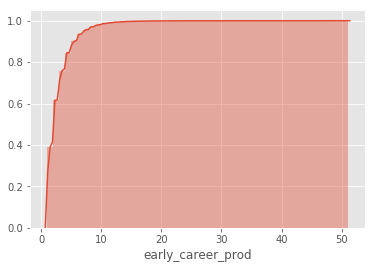

In [9]:
sns.distplot(credible_authors.early_career_prod,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
import scipy
sns.set_palette("hls", 1)

# x,y = p.get_lines()[0].get_data()

#care with the order, it is first y
#initial fills a 0 so the result has same length than x
# cdf = scipy.integrate.cumtrapz(y, x, initial=0)

# nearest_05 = np.abs(cdf-0.5).argmin()

# x_median = x[nearest_05]
# y_median = y[nearest_05]

# plt.vlines(x_median, 0, y_median)
plt.show()

### Test gender files

In [10]:
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')

In [11]:
gender_old = pd.read_csv('./data/name_gender_2017_asiansAsNone.txt')

In [12]:
# import pickle
# gender_id = pickle.load(open('./data/id_gender_2017_asiansAsNone.p', "rb" ) )
# doesnt work. Python 3 vs 2?

In [13]:
print(gender.shape)
print(gender_old.shape)

(1704919, 2)
(9471728, 2)


In [14]:
gender.head()

,name,gender
0,gareth beale,m
1,graeme earl,m
2,altaf hossain,m
3,faisal zaman,m
4,m. nasser,none


In [15]:
gender_old = gender_old.drop_duplicates()

In [16]:
gender_old[gender_old.name.str.contains("robert")]

,name,gender
365,robert a. van gorder,none
367,edward l. robertson,none
377,robert d. austin,none
505,roberto tamassia,m
520,robert warrender,none
555,roberto bortoletto,m
796,robert moss,none
1285,robert w. proctor,none
1581,robert b. gorbet,none
1605,robert chen,none


In [17]:
gender[gender.name.str.contains("jorge santos")]

,name,gender
2545,jorge santos 1,m
70490,ricardo jorge santos,m
248275,jorge santos,m
382652,jorge santos 2,m
1025928,jorge santos 3,m
1119603,jorge santos 0002,m
1337773,camillo jorge santos oliveira,m
1501066,jorge santos simón,m
1614512,esdras jorge santos barboza,m


In [18]:
## What is strange is that 'jorge santos 1' goes from none to 'm', but 'jorge santos' goes from 'm' to none

In [19]:
gender.groupby('gender').count()

,name
gender,
f,255793
m,796975
none,652151


In [20]:
gender_old.groupby('gender').count()

,name
gender,
f,255793
m,796975
none,652151


In [21]:
merged = gender.merge(gender_old, on='name', suffixes=('_new', '_old'))

In [22]:
merged.head()

,name,gender_new,gender_old
0,gareth beale,m,m
1,graeme earl,m,m
2,altaf hossain,m,m
3,faisal zaman,m,m
4,m. nasser,none,none


In [23]:
# Cases where we lose the gender by using new file ./data/name_gender_2017_asiansAsNone_nodup.txt
print(merged[(merged.gender_new != merged.gender_old) & (merged.gender_new!='none')])
print(merged[(merged.gender_new != merged.gender_old) & (merged.gender_new!='none')].shape)

Empty DataFrame
Columns: [name, gender_new, gender_old]
Index: []
(0, 3)


In [24]:
gender[gender.name.str.contains('michael r. smith')]

,name,gender
151887,michael r. smith 2,m
167781,michael r. smith 1,m
1344286,michael r. smith 0001,m
1627074,michael r. smith,m


#### Analyze people that have digits in their names

In [25]:
digits = gender[gender.name.str.contains('\d')]

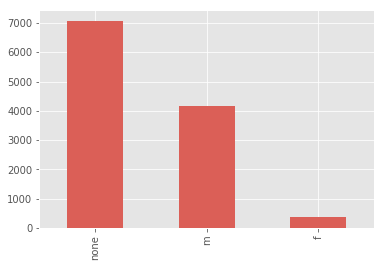

In [26]:
digits.gender.value_counts().plot(kind='bar')

In [46]:
authors_digits = credible_authors.reset_index().merge(digits, left_on='author', right_on='name')

In [47]:
digiAuthorPublicationData = authorPublicationData.merge(authors_digits, how="inner", on=["author"])

In [48]:
authors_digits.shape

(5880, 14)

In [49]:
print("Percentage of authors with numbers in names: ", authors_digits.shape[0]*100/credible_authors.shape[0])
print("Percentage of publications: ", authors_digits.num_pub.sum()*100/credible_authors.num_pub.sum())
print("Percentage of citations: ", authors_digits.final_citation_count.sum()*100/credible_authors.final_citation_count.sum())

Percentage of authors with numbers in names:  1.1669931468922854
Percentage of publications:  2.0680998909247443
Percentage of citations:  2.5078878280468806


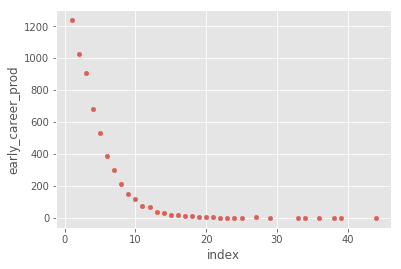

In [50]:
authors_digits.early_career_prod.value_counts().reset_index().plot(kind='scatter', x='index', y='early_career_prod')

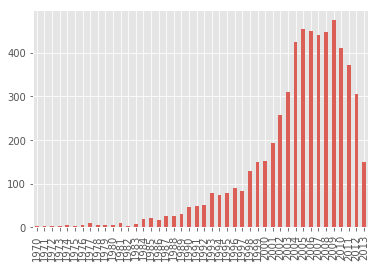

In [51]:
authors_digits.start_year.value_counts().sort_index().plot(kind='bar')

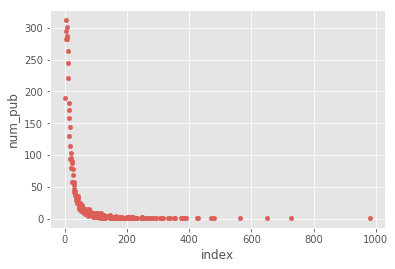

In [52]:
authors_digits.num_pub.value_counts().reset_index().plot(kind='scatter', x='index', y='num_pub')

In [53]:
authors_digits['pub_per_year'] = authors_digits.num_pub / authors_digits.career_length

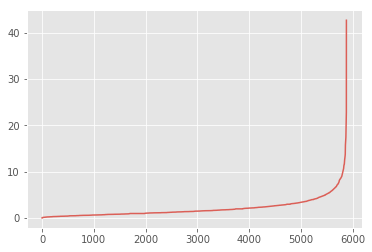

In [54]:
plt.plot(sorted(authors_digits['pub_per_year']))
plt.show()

In [55]:
authors_digits[authors_digits['pub_per_year'] > 10]

,index,author,start_year,end_year,num_pub,career_length,early_career_qual,early_career_prod,early_career_pubs,early_career_rec,gender_x,final_citation_count,name,gender_y,pub_per_year
58,11294,albrecht schmidt 1,1998,2017,339,20,127.0,16,"['c787697c-355a-4165-b6a2-6e4a6268bbfa', '0b20...",0,m,5287.0,albrecht schmidt 1,m,16.950000
225,28811,anil k. jain 1,1976,2017,425,42,13.0,3,"['cfea5778-a9a5-464c-b7d4-f7d54eb26966', '575c...",0,m,26756.0,anil k. jain 1,m,10.119048
335,47114,bernd becker 1,1983,2017,352,35,0.0,2,"['bf4a1dca-9b6c-4d01-a7da-918a82202f66', '153e...",0,m,2602.0,bernd becker 1,m,10.057143
361,49105,bin liu 1,2003,2017,155,15,44.0,23,"['fd43d50a-18b3-49bd-bc0b-ea7c79d80c87', '1421...",0,none,1240.0,bin liu 1,none,10.333333
572,63431,chao wang 3,2011,2017,76,7,101.0,38,"['27007e84-aa7e-48aa-813a-d77112f0ddc4', '48f4...",0,none,179.0,chao wang 3,none,10.857143
623,65663,cheng wang 3,2013,2017,58,5,105.0,34,"['8e27763e-c3f2-4361-8017-9bb186c6627f', '995f...",0,none,123.0,cheng wang 3,none,11.600000
946,95651,david zhang 1,1994,2017,481,24,0.0,6,"['cec2f304-ca4a-4918-8013-8d4fcffbc1e4', '0bf0...",0,none,11643.0,david zhang 1,none,20.041667
1115,125090,fei wang 1,2004,2017,159,14,55.0,11,"['08d97df5-1941-40ce-95db-1307b2dba1ba', 'c768...",0,none,2508.0,fei wang 1,none,11.357143
1479,158505,haris aziz 1,2008,2017,104,10,206.0,11,"['610af8c4-5b88-41a1-ae2c-bb63ef255b46', '5966...",0,m,963.0,haris aziz 1,m,10.400000
1593,172058,hui li 6,2007,2017,179,11,4.0,9,"['b11fd7c5-a39f-440a-9c7d-f27ccf629fe2', '3993...",0,none,1038.0,hui li 6,none,16.272727


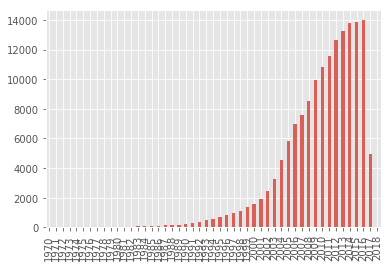

In [56]:
digiAuthorPublicationData.year.value_counts().sort_index().plot(kind='bar')

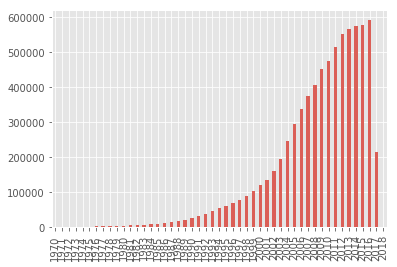

In [57]:
authorPublicationData.year.value_counts().sort_index().plot(kind='bar')

## Citations distribution (based on IDs file)

In [58]:
citation_distribution = credible_authors['final_citation_count'].value_counts().sort_index()

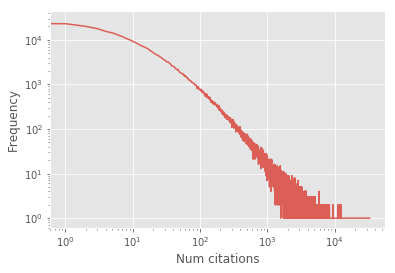

In [59]:
plt.loglog(citation_distribution.index, citation_distribution.values)
plt.xlabel('Num citations')
plt.ylabel('Frequency')
plt.show()

## Early Career Prod. vs Final Success (ID file)

In [60]:
credible_authors.sort_values(by='early_career_prod', inplace=True)

In [61]:
x = credible_authors['early_career_prod']
y = credible_authors['final_citation_count']

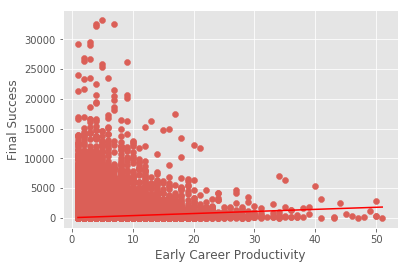

In [62]:
fig, ax = plt.subplots()
plt.scatter(x, y)
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Early Career Productivity')
plt.ylabel('Final Success')
# plt.xlim(0, 50)
# plt.ylim(0,200)
plt.show()

In [63]:
credible_authors_no_uncited = credible_authors.dropna()

In [64]:
x = credible_authors_no_uncited['early_career_prod']
y = credible_authors_no_uncited['final_citation_count']

In [65]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value)
print(slope, intercept)

0.1599975788916418
34.960743634955534 38.4926283228165


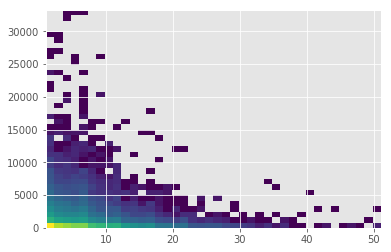

In [66]:
fig, axs = plt.subplots()
axs.hist2d(x, y, bins=40, norm=colors.LogNorm())
plt.show()

## Early Career Prod. vs Early Career Qual. (IDs file)

In [67]:
credible_authors.sort_values(by='early_career_prod', inplace=True)

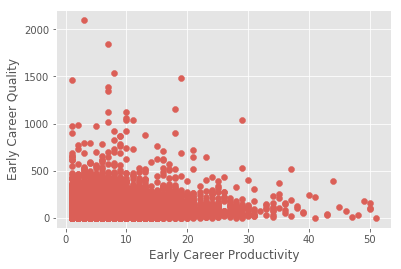

In [68]:
plt.scatter(credible_authors['early_career_prod'], credible_authors['early_career_qual'])
plt.xlabel('Early Career Productivity')
plt.ylabel('Early Career Quality')
plt.show()